ED columns: ['ed_intime', 'ed_outtime', 'ed_los', 'ed_stay_id']
Troponin columns: ['first_troponin_charttime', 'troponin_end_charttime', 'first_troponin_positive_charttime', 'troponin_count']

=== Missing values ===
ed_intime                              0
ed_outtime                             0
ed_los                                 0
ed_stay_id                             0
first_troponin_charttime             591
troponin_end_charttime               591
first_troponin_positive_charttime    880
troponin_count                         0
dtype: int64

Missing ratio:
ed_intime                            0.0000
ed_outtime                           0.0000
ed_los                               0.0000
ed_stay_id                           0.0000
first_troponin_charttime             0.3062
troponin_end_charttime               0.3062
first_troponin_positive_charttime    0.4560
troponin_count                       0.0000
dtype: float64

=== Basic describe (numeric) ===
            ed_los    ed_s

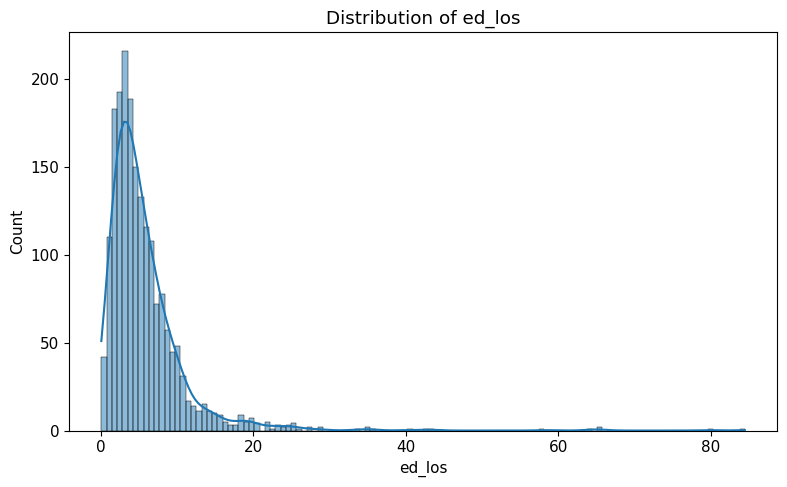

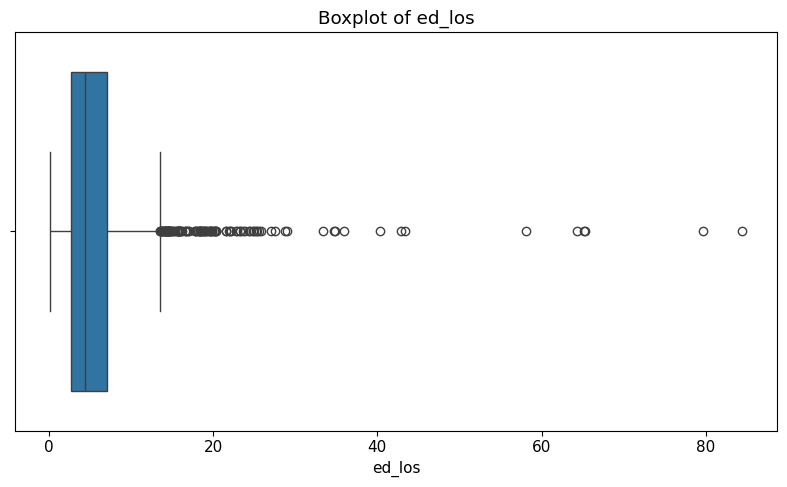

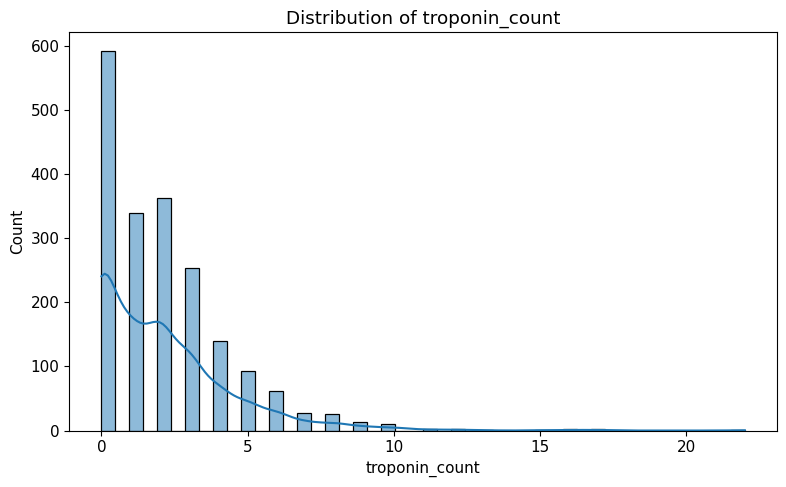

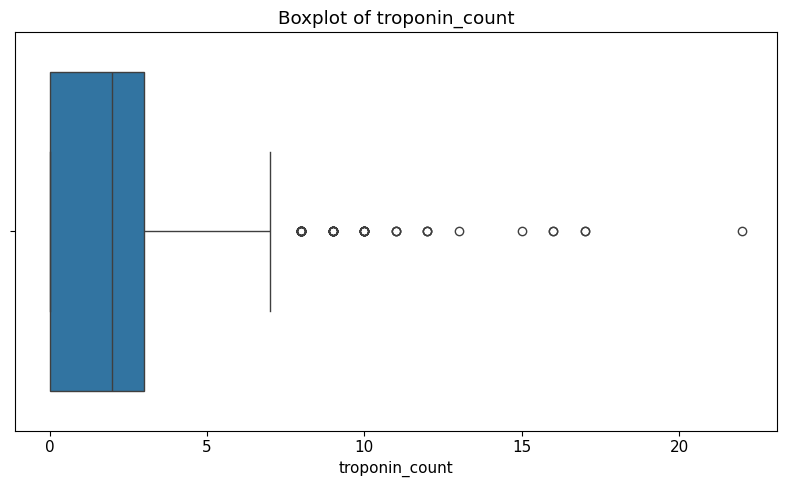


=== IQR Outlier Summary ===

[ ed_los ]
q1: 2.7186805557500002
q3: 7.05104166675
iqr: 4.332361110999999
lower: -3.7798611107499984
upper: 13.549583333249998
outlier_count: 110
outlier_ratio: 0.05699481865284974

[ troponin_count ]
q1: 0.0
q3: 3.0
iqr: 3.0
lower: -4.5
upper: 7.5
outlier_count: 61
outlier_ratio: 0.031606217616580314

=== Time logic checks ===
ED time inverted rows: 0
Troponin time inverted rows: 0
Positive troponin before first_troponin rows: 0

Selected y label column: icu_los

=== Relationship with Y = icu_los ===
Y is treated as numeric/continuous. Making scatter & correlation.


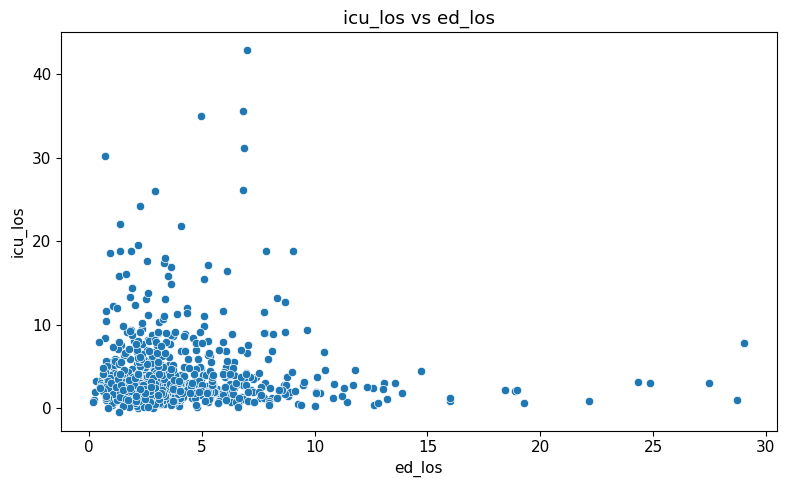

Correlation between ed_los and icu_los: -0.0139


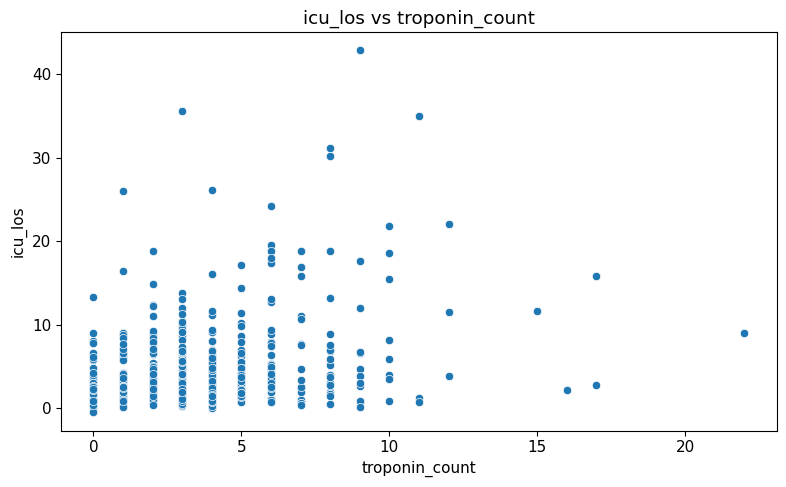

Correlation between troponin_count and icu_los: 0.3120

=== Correlation matrix ===
                  ed_los  troponin_count   icu_los
ed_los          1.000000        0.069672 -0.013935
troponin_count  0.069672        1.000000  0.311993
icu_los        -0.013935        0.311993  1.000000


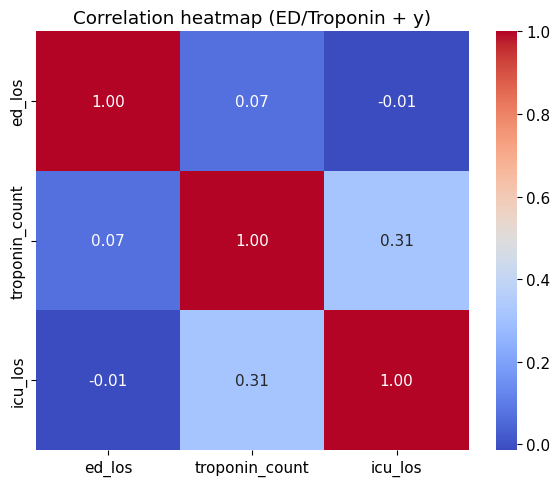


EDA finished.


In [1]:
"""
EDA for ED & Troponin columns in cohort_ver47_with_cci_hfrs.csv

- Outlier (IQR 기준)
- Noise (시간 역전 등 간단한 논리 검증)
- 결측치 확인
- 분포(histo, boxplot)
- y(label)과의 관계 (los / dod 중 존재하는 것 우선 사용)
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# ----------------------------------
# 0. 기본 설정
# ----------------------------------
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 11

# 파일 경로만 맞게 수정
DATA_PATH = "./cohort/cohort_ver47_with_cci_hfrs.csv"


# ----------------------------------
# 1. 데이터 로드
# ----------------------------------
def load_data(path: str) -> pd.DataFrame:
    # 날짜형으로 파싱할 후보 컬럼
    parse_date_candidates = [
        "ed_intime", "ed_outtime",
        "first_troponin_charttime",
        "troponin_end_charttime",
        "first_troponin_positive_charttime",
    ]
    parse_dates = [c for c in parse_date_candidates if os.path.exists(path)]

    df = pd.read_csv(path)

    # 날짜형 변환 (있을 때만)
    for col in parse_date_candidates:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

    return df


df = load_data(DATA_PATH)

# ED / Troponin 관련 컬럼 정의
ed_cols = [c for c in df.columns if c in ["ed_intime", "ed_outtime", "ed_los", "ed_stay_id"]]
tro_cols = [
    c
    for c in df.columns
    if c
    in [
        "first_troponin_charttime",
        "troponin_end_charttime",
        "first_troponin_positive_charttime",
        "troponin_count",
    ]
]

print("ED columns:", ed_cols)
print("Troponin columns:", tro_cols)


# ----------------------------------
# 2. 결측치 확인
# ----------------------------------
def check_missing(df: pd.DataFrame, cols: list):
    print("\n=== Missing values ===")
    missing = df[cols].isna().sum()
    print(missing)
    print("\nMissing ratio:")
    print((missing / len(df)).round(4))


check_missing(df, ed_cols + tro_cols)


# ----------------------------------
# 3. 기본 통계량 & 분포 확인
# ----------------------------------
def basic_describe(df: pd.DataFrame, cols: list):
    print("\n=== Basic describe (numeric) ===")
    print(df[cols].describe(include="number"))

    print("\n=== Basic describe (object / datetime) ===")
    non_num_cols = [c for c in cols if not np.issubdtype(df[c].dtype, np.number)]
    if non_num_cols:
        print(df[non_num_cols].describe(include="all"))
    else:
        print("No non-numeric columns in selection.")


basic_describe(df, ed_cols + tro_cols)


def plot_distribution(df: pd.DataFrame):
    # 수치형만 필터
    num_cols = []
    for c in ["ed_los", "troponin_count"]:
        if c in df.columns:
            num_cols.append(c)

    for col in num_cols:
        plt.figure()
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

        # boxplot (outlier 시각화)
        plt.figure()
        sns.boxplot(x=df[col].dropna())
        plt.title(f"Boxplot of {col}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()


plot_distribution(df)


# ----------------------------------
# 4. IQR 기반 Outlier 탐지
# ----------------------------------
def iqr_outlier_info(series: pd.Series) -> dict:
    series = series.dropna()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask_out = (series < lower) | (series > upper)
    return {
        "q1": q1,
        "q3": q3,
        "iqr": iqr,
        "lower": lower,
        "upper": upper,
        "outlier_count": int(mask_out.sum()),
        "outlier_ratio": float(mask_out.mean()),
    }


print("\n=== IQR Outlier Summary ===")
for col in ["ed_los", "troponin_count"]:
    if col in df.columns:
        info = iqr_outlier_info(df[col])
        print(f"\n[ {col} ]")
        for k, v in info.items():
            print(f"{k}: {v}")


# ----------------------------------
# 5. Noise / 논리 검증 (간단히)
# ----------------------------------
def check_time_noise(df: pd.DataFrame):
    print("\n=== Time logic checks ===")

    # ED 시간 역전
    if "ed_intime" in df.columns and "ed_outtime" in df.columns:
        invalid_ed = df["ed_outtime"] < df["ed_intime"]
        print(f"ED time inverted rows: {invalid_ed.sum()}")

    # Troponin 측정 시간 순서
    if (
        "first_troponin_charttime" in df.columns
        and "troponin_end_charttime" in df.columns
    ):
        invalid_trop = (
            df["troponin_end_charttime"] < df["first_troponin_charttime"]
        )
        print(f"Troponin time inverted rows: {invalid_trop.sum()}")

    # 양성 Troponin 시간이 첫 Troponin보다 이전인 경우
    if (
        "first_troponin_charttime" in df.columns
        and "first_troponin_positive_charttime" in df.columns
    ):
        invalid_pos = (
            df["first_troponin_positive_charttime"]
            < df["first_troponin_charttime"]
        )
        # NaN 제외
        invalid_pos = invalid_pos & df["first_troponin_positive_charttime"].notna()
        print(f"Positive troponin before first_troponin rows: {invalid_pos.sum()}")


check_time_noise(df)


# ----------------------------------
# 6. y label(los / dod)과의 관계 분석
#    - los 또는 dod 중 존재하는 첫 컬럼 사용
# ----------------------------------
def choose_y_column(df: pd.DataFrame):
    # 우선순위: los 계열 -> dod 계열
    los_candidates = [
        "los", "los_hosp", "hosp_los", "los_icu", "icu_los",
        "ed_los_total",
    ]
    dod_candidates = ["dod", "death", "in_hosp_death", "in_hospital_mortality"]

    for col in los_candidates:
        if col in df.columns:
            return col
    for col in dod_candidates:
        if col in df.columns:
            return col
    return None


y_col = choose_y_column(df)
print(f"\nSelected y label column: {y_col}")

def is_binary(series: pd.Series) -> bool:
    vals = series.dropna().unique()
    if len(vals) <= 2 and set(vals).issubset({0, 1}):
        return True
    return False


def analyze_with_y(df: pd.DataFrame, y_col: str):
    if y_col is None:
        print("No y label (los/dod) column found. Skip Y-related EDA.")
        return

    y = df[y_col]

    # ED & troponin 수치형 후보
    feature_cols = []
    for c in ["ed_los", "troponin_count"]:
        if c in df.columns:
            feature_cols.append(c)

    if not feature_cols:
        print("No numeric ED/Troponin feature columns found for Y-analysis.")
        return

    print(f"\n=== Relationship with Y = {y_col} ===")

    if is_binary(y):
        print("Y is treated as binary (0/1). Making boxplots per class.")
        for col in feature_cols:
            plt.figure()
            sns.boxplot(x=y, y=df[col])
            plt.xlabel(y_col)
            plt.ylabel(col)
            plt.title(f"{col} by {y_col}")
            plt.tight_layout()
            plt.show()

            # 간단 평균 비교
            print(f"\n[{col}] mean by {y_col}:")
            print(df.groupby(y_col)[col].mean())
    else:
        print("Y is treated as numeric/continuous. Making scatter & correlation.")
        for col in feature_cols:
            # scatter
            plt.figure()
            sns.scatterplot(x=df[col], y=y)
            plt.xlabel(col)
            plt.ylabel(y_col)
            plt.title(f"{y_col} vs {col}")
            plt.tight_layout()
            plt.show()

            # 상관계수
            valid = df[[col, y_col]].dropna()
            if len(valid) > 1:
                corr = valid[col].corr(valid[y_col])
                print(f"Correlation between {col} and {y_col}: {corr:.4f}")


analyze_with_y(df, y_col)


# ----------------------------------
# 7. 추가: 간단 상관 행렬 (ED/Troponin + y)
# ----------------------------------
def correlation_heatmap(df: pd.DataFrame, y_col: str):
    cols = []
    for c in ["ed_los", "troponin_count"]:
        if c in df.columns:
            cols.append(c)
    if y_col is not None and y_col in df.columns:
        if np.issubdtype(df[y_col].dtype, np.number):
            cols.append(y_col)

    cols = list(dict.fromkeys(cols))  # unique
    if len(cols) <= 1:
        print("Not enough numeric columns for correlation heatmap.")
        return

    corr_df = df[cols].dropna()
    corr = corr_df.corr()

    print("\n=== Correlation matrix ===")
    print(corr)

    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation heatmap (ED/Troponin + y)")
    plt.tight_layout()
    plt.show()


correlation_heatmap(df, y_col)

print("\nEDA finished.")


=== New column created: troponin_delay_min (minutes) ===
0     293.0
1       NaN
2     349.0
3    1012.0
4      91.0
Name: troponin_delay_min, dtype: float64

=== Missing check: troponin_delay_min ===
Missing count: 591
Missing ratio: 0.3062


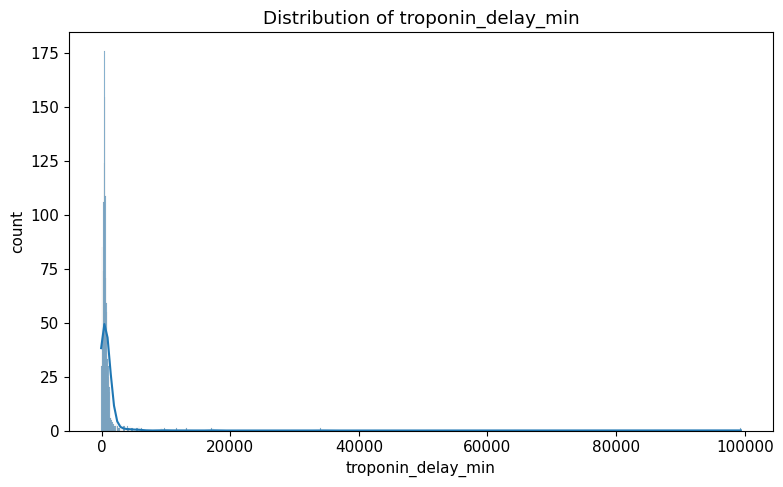

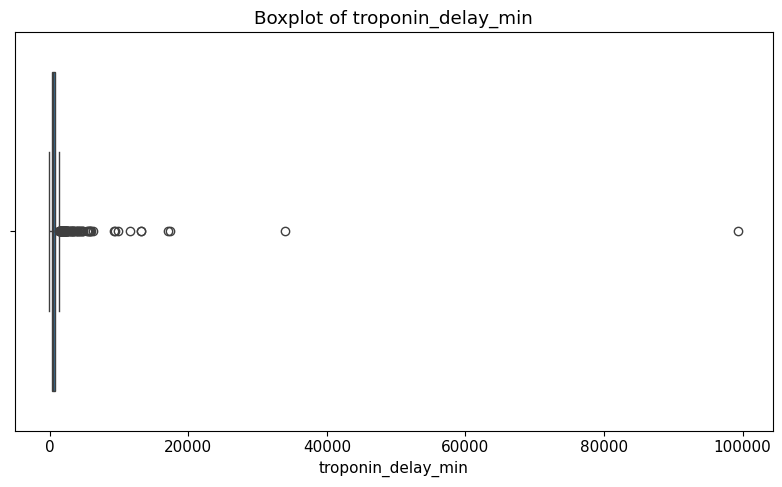


=== IQR Outlier Analysis: troponin_delay_min ===
Q1: 326.500
Q3: 754.000
IQR: 427.500
Lower bound: -314.750
Upper bound: 1395.250
Outlier count: 83
Outlier ratio: 0.0620

=== Time Logic Checks for troponin_delay ===
Negative delay count: 4
Delay > 24h count: 79

Selected y-col: icu_los


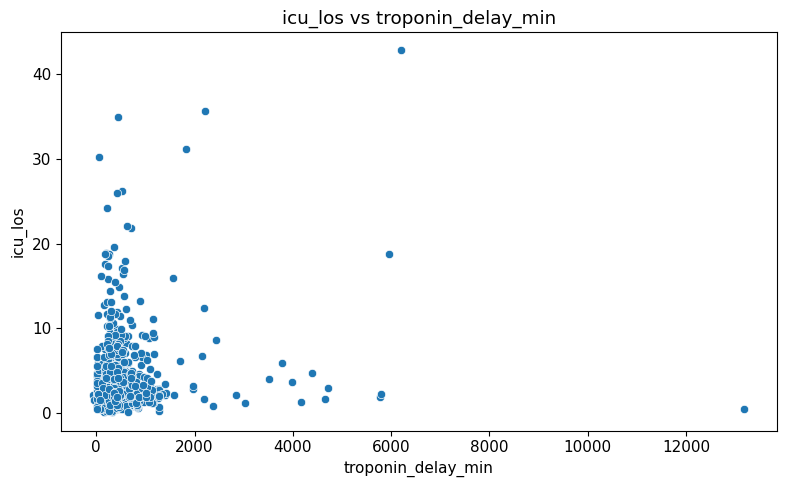

Correlation:                     troponin_delay_min   icu_los
troponin_delay_min            1.000000  0.101579
icu_los                       0.101579  1.000000

=== EDA Completed ===


In [2]:
"""
Troponin 첫 검사 시간 - 병원 입원시간(ed_intime)
새 파생 변수 생성 후 EDA 전체 수행 코드
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 11

# ----------------------------------------------------
# 1. Load Data
# ----------------------------------------------------
DATA_PATH = "./cohort/cohort_ver47_with_cci_hfrs.csv"

def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # 날짜형 변환 후보
    date_cols = [
        "ed_intime", "ed_outtime",
        "ed_intime", "dischtime",
        "first_troponin_charttime", "troponin_end_charttime",
        "first_troponin_positive_charttime"
    ]

    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

    return df

df = load_data(DATA_PATH)

# ----------------------------------------------------
# 2. 새 컬럼 생성: Troponin 검사 지연 시간
#     first_troponin_charttime - ed_intime (단위: minutes)
# ----------------------------------------------------
if "first_troponin_charttime" not in df.columns or "ed_intime" not in df.columns:
    raise ValueError("필요한 컬럼(first_troponin_charttime, ed_intime)이 없습니다.")

df["troponin_delay_min"] = (
    (df["first_troponin_charttime"] - df["ed_intime"])
    .dt.total_seconds() / 60
)

print("=== New column created: troponin_delay_min (minutes) ===")
print(df["troponin_delay_min"].head())


# ----------------------------------------------------
# 3. Missing 확인
# ----------------------------------------------------
def check_missing(series: pd.Series, name: str):
    print(f"\n=== Missing check: {name} ===")
    missing = series.isna().sum()
    print(f"Missing count: {missing}")
    print(f"Missing ratio: {missing / len(series):.4f}")

check_missing(df["troponin_delay_min"], "troponin_delay_min")


# ----------------------------------------------------
# 4. 기본 분포 확인
# ----------------------------------------------------
def plot_distribution(series: pd.Series, name: str):
    clean = series.dropna()

    plt.figure()
    sns.histplot(clean, kde=True)
    plt.title(f"Distribution of {name}")
    plt.xlabel(name)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    plt.figure()
    sns.boxplot(x=clean)
    plt.title(f"Boxplot of {name}")
    plt.xlabel(name)
    plt.tight_layout()
    plt.show()

plot_distribution(df["troponin_delay_min"], "troponin_delay_min")


# ----------------------------------------------------
# 5. IQR 기반 이상치(outlier) 분석
# ----------------------------------------------------
def iqr_outlier(series: pd.Series, name: str):
    clean = series.dropna()
    q1 = clean.quantile(0.25)
    q3 = clean.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_count = ((clean < lower) | (clean > upper)).sum()

    print(f"\n=== IQR Outlier Analysis: {name} ===")
    print(f"Q1: {q1:.3f}")
    print(f"Q3: {q3:.3f}")
    print(f"IQR: {iqr:.3f}")
    print(f"Lower bound: {lower:.3f}")
    print(f"Upper bound: {upper:.3f}")
    print(f"Outlier count: {outlier_count}")
    print(f"Outlier ratio: {outlier_count / len(clean):.4f}")

iqr_outlier(df["troponin_delay_min"], "troponin_delay_min")


# ----------------------------------------------------
# 6. 시간 논리 검증
# ----------------------------------------------------
def time_logic_check(df):
    print("\n=== Time Logic Checks for troponin_delay ===")

    # 음수 delay → 입원 전에 Troponin 검사했다는 뜻 (보통 Noise)
    negative_delay = (df["troponin_delay_min"] < 0).sum()
    print(f"Negative delay count: {negative_delay}")

    # 비정상적으로 큰 delay (예: > 24시간?)
    very_large = (df["troponin_delay_min"] > 60 * 24).sum()
    print(f"Delay > 24h count: {very_large}")

time_logic_check(df)


# ----------------------------------------------------
# 7. y label(los / dod)과의 관계 분석 (optional)
# ----------------------------------------------------
def choose_y_column(df):
    los_cols = ["los", "hosp_los", "icu_los", "ed_los"]
    dod_cols = ["dod", "death", "in_hosp_death"]

    for col in los_cols:
        if col in df.columns:
            return col
    for col in dod_cols:
        if col in df.columns:
            return col
    return None

y_col = choose_y_column(df)
print(f"\nSelected y-col: {y_col}")

def analyze_with_y(df, y_col):
    if y_col is None:
        print("Y label 없음. 분석 생략.")
        return

    series = df["troponin_delay_min"]

    if df[y_col].dropna().nunique() <= 2:
        # binary
        plt.figure()
        sns.boxplot(x=df[y_col], y=series)
        plt.title(f"{y_col} vs troponin_delay_min")
        plt.tight_layout()
        plt.show()

        print(df.groupby(y_col)["troponin_delay_min"].describe())
    else:
        # continuous
        plt.figure()
        sns.scatterplot(x=series, y=df[y_col])
        plt.title(f"{y_col} vs troponin_delay_min")
        plt.tight_layout()
        plt.show()

        print("Correlation:", df[[series.name, y_col]].corr())

analyze_with_y(df, y_col)


print("\n=== EDA Completed ===")



==================== RAW troponin_delay_min EDA ====================

=== Missing check: troponin_delay_min ===
Missing count: 591
Missing ratio: 0.3062


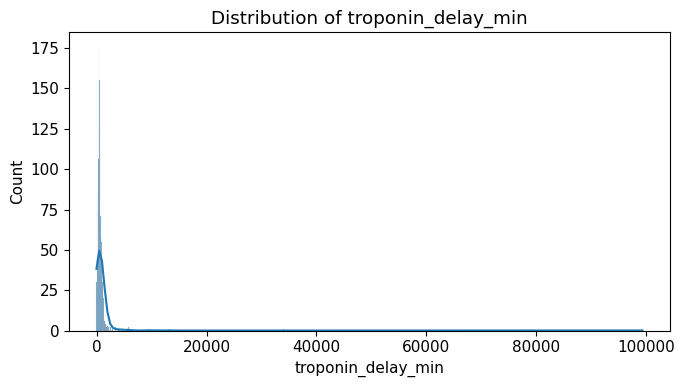

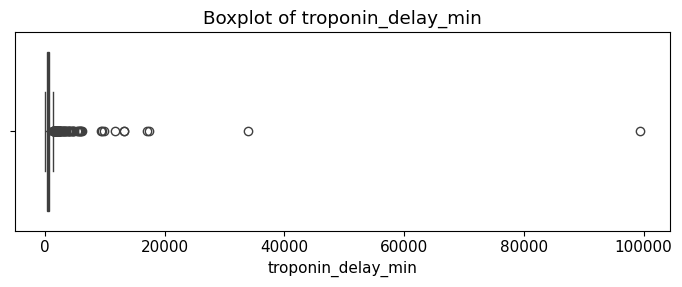


=== IQR Outlier Analysis: troponin_delay_min ===
Q1 = 326.500
Q3 = 754.000
IQR = 427.500
Lower bound = -314.750
Upper bound = 1395.250
Outlier count = 83 (0.0620)


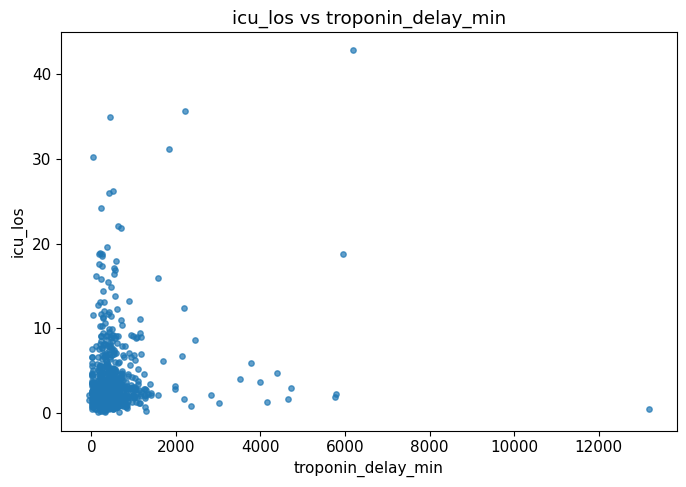


Correlation (troponin_delay_min vs icu_los): 0.1016


==================== TRIMMED (5~95%) troponin_delay_min EDA ====================
Lower 5% cutoff:  30.900
Upper 95% cutoff: 1607.700
Remaining rows:   1205

=== Missing check: trimmed_troponin_delay_min ===
Missing count: 0
Missing ratio: 0.0000


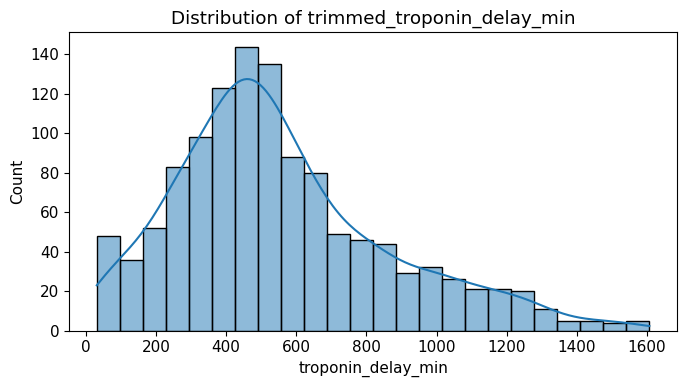

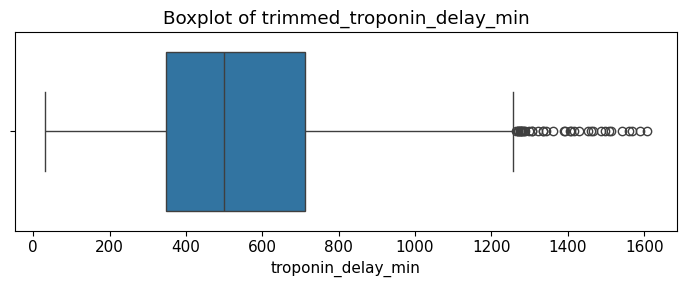


=== IQR Outlier Analysis: trimmed_troponin_delay_min ===
Q1 = 349.000
Q3 = 713.000
IQR = 364.000
Lower bound = -197.000
Upper bound = 1259.000
Outlier count = 38 (0.0315)


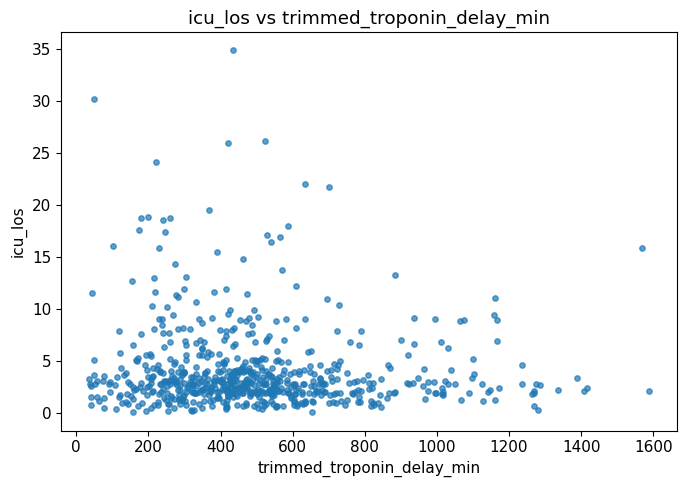


Correlation (trimmed_troponin_delay_min vs icu_los): -0.0744

=== DONE ===


In [3]:
"""
상하위 5% 이상치 제거 후 troponin_delay_min 재-EDA 코드
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# =========================================================
# 1. Load
# =========================================================
DATA_PATH = "./cohort/cohort_ver47_with_cci_hfrs.csv"

def load_data(path):
    df = pd.read_csv(path)

    # 날짜 변환
    date_cols = [
        "ed_intime", "ed_outtime",
        "ed_intime", "admittime",
        "first_troponin_charttime",
        "troponin_end_charttime",
        "first_troponin_positive_charttime"
    ]
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")
    return df

df = load_data(DATA_PATH)


# =========================================================
# 2. troponin_delay_min 생성 (ed_intime 기준 예시)
# =========================================================
if "first_troponin_charttime" not in df.columns or "ed_intime" not in df.columns:
    raise ValueError("필수 컬럼(first_troponin_charttime, ed_intime)이 없습니다.")

df["troponin_delay_min"] = (df["first_troponin_charttime"] - df["ed_intime"]).dt.total_seconds()/60


# =========================================================
# 3. 상·하위 5% 이상치 cut 함수
# =========================================================
def trim_outliers(series: pd.Series, lower_q=0.05, upper_q=0.95):
    """
    series의 상하위 quantile 기준으로 trim한 series를 반환.
    """
    lower = series.quantile(lower_q)
    upper = series.quantile(upper_q)
    trimmed = series[(series >= lower) & (series <= upper)]
    return trimmed, lower, upper


# =========================================================
# 4. EDA 함수들
# =========================================================
def check_missing(series, name):
    print(f"\n=== Missing check: {name} ===")
    print(f"Missing count: {series.isna().sum()}")
    print(f"Missing ratio: {series.isna().mean():.4f}")

def plot_dist(series, name):
    clean = series.dropna()
    plt.figure(figsize=(7,4))
    sns.histplot(clean, kde=True)
    plt.title(f"Distribution of {name}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,3))
    sns.boxplot(x=clean)
    plt.title(f"Boxplot of {name}")
    plt.tight_layout()
    plt.show()

def iqr_outlier(series, name):
    clean = series.dropna()
    q1 = clean.quantile(0.25)
    q3 = clean.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_count = ((clean < lower) | (clean > upper)).sum()

    print(f"\n=== IQR Outlier Analysis: {name} ===")
    print(f"Q1 = {q1:.3f}")
    print(f"Q3 = {q3:.3f}")
    print(f"IQR = {iqr:.3f}")
    print(f"Lower bound = {lower:.3f}")
    print(f"Upper bound = {upper:.3f}")
    print(f"Outlier count = {outlier_count} ({outlier_count/len(clean):.4f})")


def scatter_with_y(series, y, name):
    clean_df = pd.DataFrame({name: series, "y": y}).dropna()

    plt.figure(figsize=(7,5))
    plt.scatter(clean_df[name], clean_df["y"], s=15, alpha=0.7)
    plt.title(f"{y.name} vs {name}")
    plt.xlabel(name)
    plt.ylabel(y.name)
    plt.tight_layout()
    plt.show()

    # 상관계수
    corr = clean_df[name].corr(clean_df["y"])
    print(f"\nCorrelation ({name} vs {y.name}): {corr:.4f}")


# =========================================================
# 5. 실제 적용
# =========================================================
raw = df["troponin_delay_min"]
icu_los = df["icu_los"] if "icu_los" in df.columns else None

print("\n==================== RAW troponin_delay_min EDA ====================")
check_missing(raw, "troponin_delay_min")
plot_dist(raw, "troponin_delay_min")
iqr_outlier(raw, "troponin_delay_min")
if icu_los is not None:
    scatter_with_y(raw, icu_los, "troponin_delay_min")


# ----------------- 상하위 5% 이상치 제거 -----------------
trimmed, low_cut, high_cut = trim_outliers(raw, 0.05, 0.95)

print("\n\n==================== TRIMMED (5~95%) troponin_delay_min EDA ====================")
print(f"Lower 5% cutoff:  {low_cut:.3f}")
print(f"Upper 95% cutoff: {high_cut:.3f}")
print(f"Remaining rows:   {trimmed.notna().sum()}")

check_missing(trimmed, "trimmed_troponin_delay_min")
plot_dist(trimmed, "trimmed_troponin_delay_min")
iqr_outlier(trimmed, "trimmed_troponin_delay_min")

if icu_los is not None:
    scatter_with_y(trimmed, icu_los, "trimmed_troponin_delay_min")

print("\n=== DONE ===")



=== ED Columns ===
['ed_intime', 'ed_outtime', 'ed_los', 'ed_stay_id']

=== Troponin Columns ===
['first_troponin_charttime', 'troponin_end_charttime', 'first_troponin_positive_charttime', 'troponin_count']

=== Missing ratio ===
first_troponin_positive_charttime    0.455959
first_troponin_charttime             0.306218
troponin_end_charttime               0.306218
ed_intime                            0.000000
ed_stay_id                           0.000000
ed_los                               0.000000
ed_outtime                           0.000000
troponin_count                       0.000000
dtype: float64

=== Summary Statistics (numeric) ===
            ed_los    ed_stay_id  troponin_count
count  1930.000000  1.930000e+03     1930.000000
mean      5.791802  3.505265e+07        2.080829
std       5.828443  2.908779e+06        2.307311
min       0.101389  3.001462e+07        0.000000
25%       2.718681  3.248130e+07        0.000000
50%       4.400000  3.513115e+07        2.000000
75%  

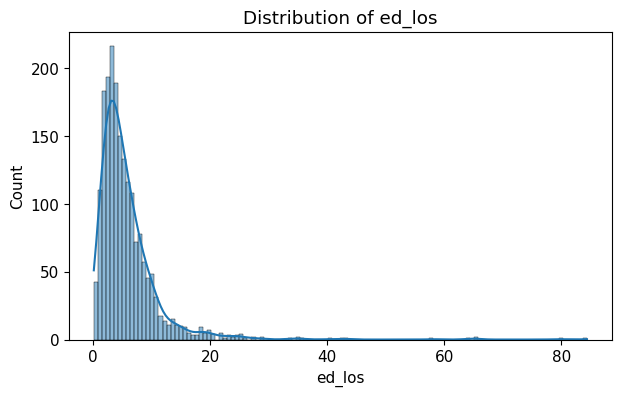

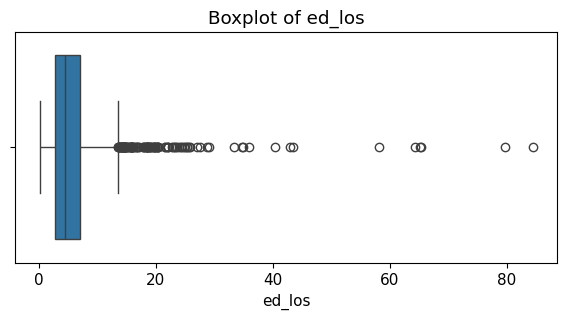

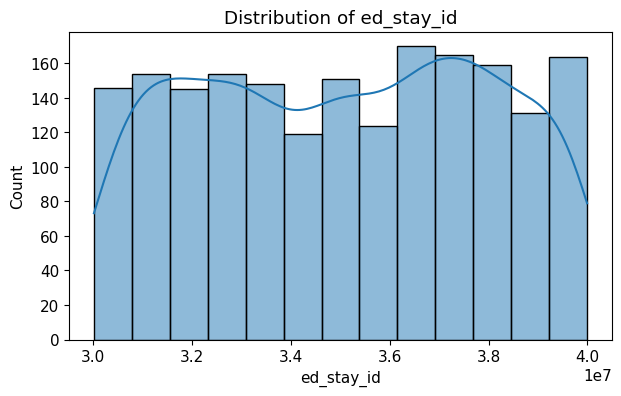

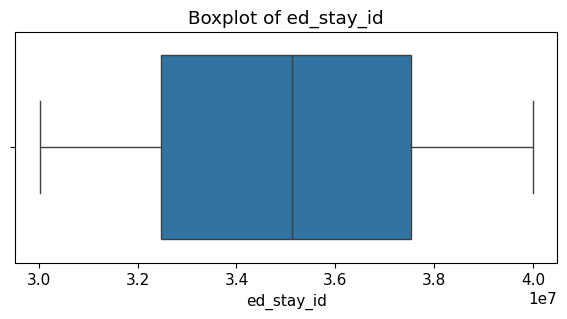

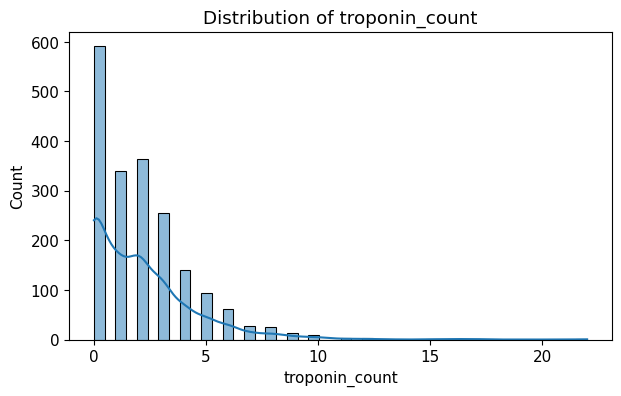

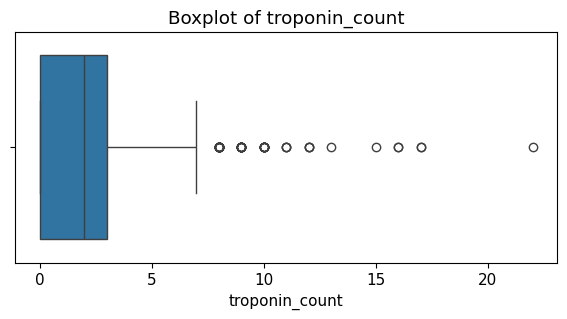


=== Created time features ===
   door_to_trop_min  admit_to_trop_min
0             293.0              189.0
1               NaN                NaN
2             349.0           -21430.0
3            1012.0                NaN
4              91.0                NaN


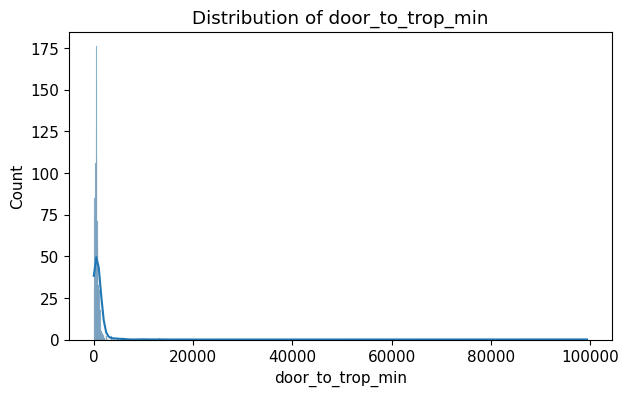

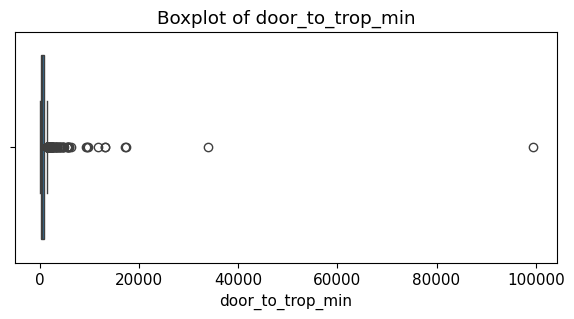

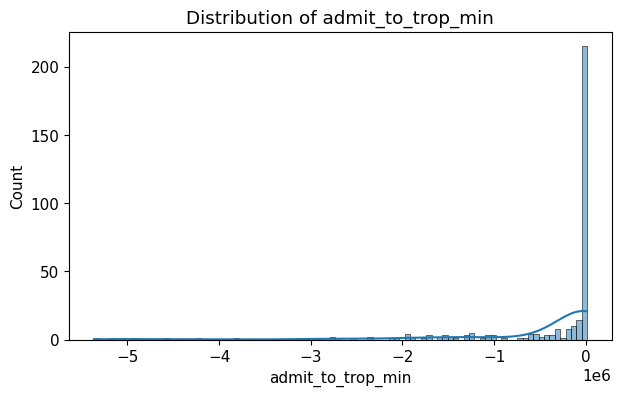

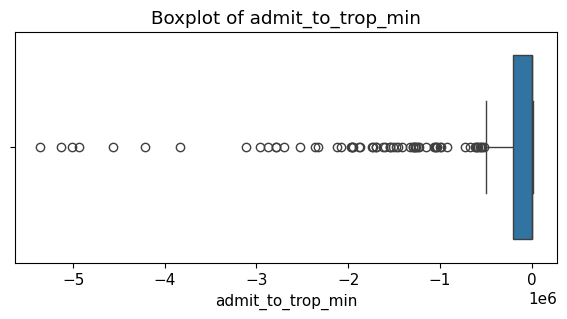

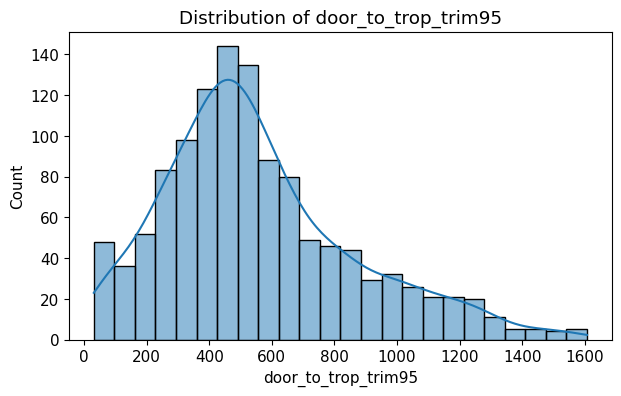

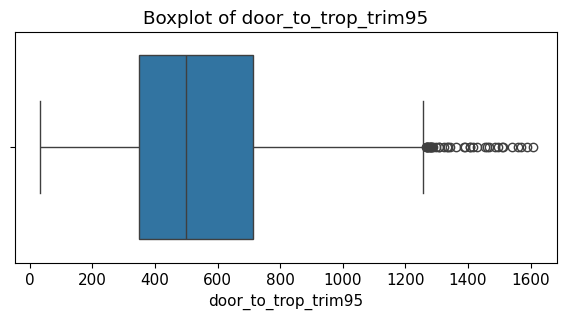


Selected y-col: icu_los


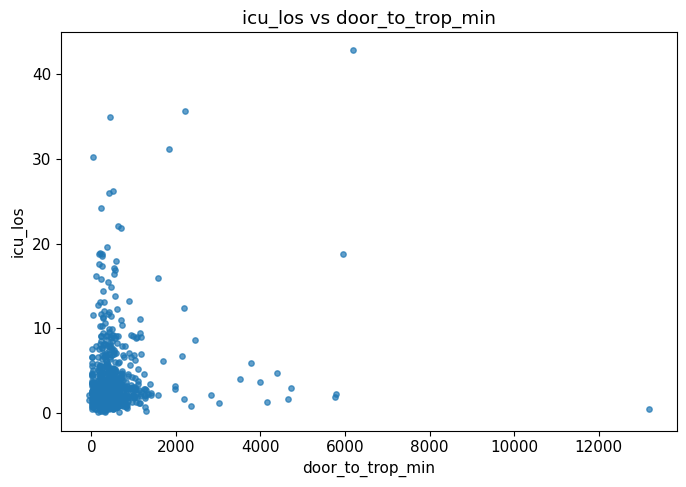

Correlation(door_to_trop_min, icu_los) = 0.1016


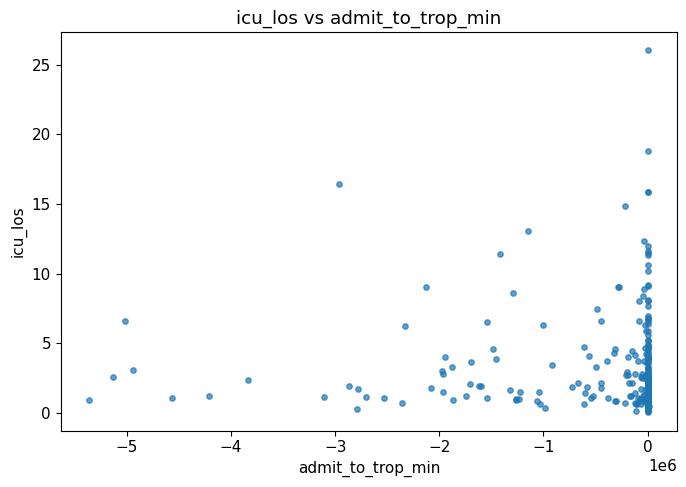

Correlation(admit_to_trop_min, icu_los) = 0.0027


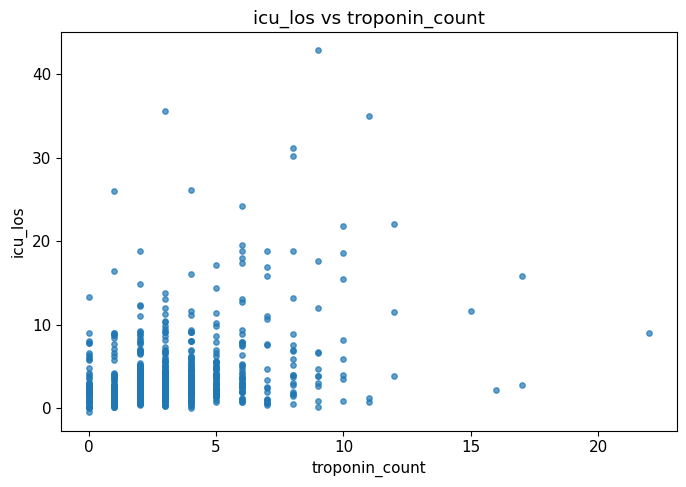

Correlation(troponin_count, icu_los) = 0.3120


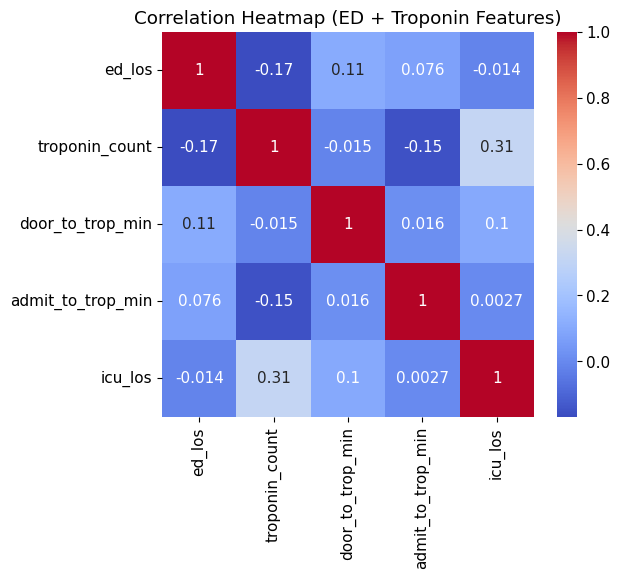

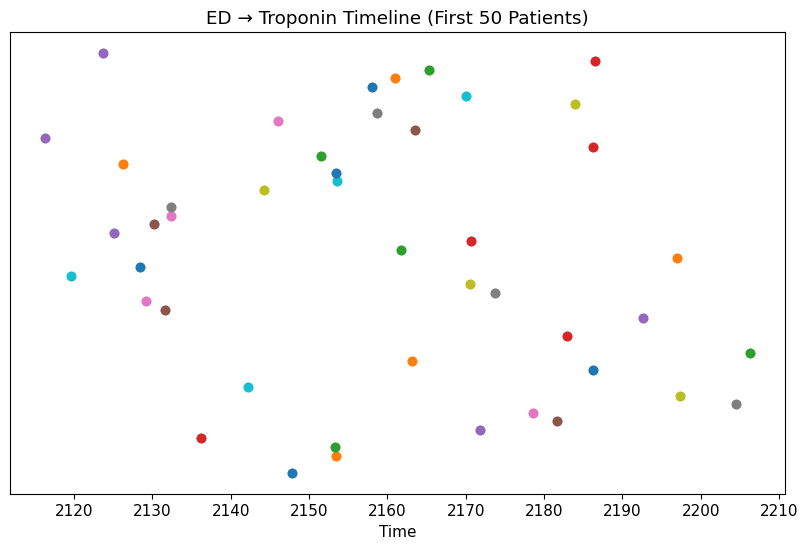


=== FULL ED+Troponin EDA Completed ===


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["font.size"] = 11

# =========================================================
# 1. LOAD
# =========================================================
DATA_PATH = "./cohort/cohort_ver47_with_cci_hfrs.csv"

def load_data(path):
    df = pd.read_csv(path)

    dt_cols = [
        "ed_intime", "ed_outtime",
        "admittime", "dischtime",
        "icu_intime", "icu_outtime",
        "first_troponin_charttime", "troponin_end_charttime",
        "first_troponin_positive_charttime"
    ]

    for col in dt_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")
    return df

df = load_data(DATA_PATH)

# =========================================================
# 2. SELECT ED & TROPNIN COLS
# =========================================================
ed_cols = [
    c for c in df.columns 
    if c.startswith("ed_") or c in ["ed_intime", "ed_outtime", "ed_los"]
]

trop_cols = [
    "first_troponin_charttime",
    "troponin_end_charttime",
    "first_troponin_positive_charttime",
    "troponin_count"
]

used_cols = [c for c in ed_cols + trop_cols if c in df.columns]

print("\n=== ED Columns ===")
print(ed_cols)
print("\n=== Troponin Columns ===")
print(trop_cols)


# =========================================================
# 3. BASIC MISSING CHECK
# =========================================================
print("\n=== Missing ratio ===")
print((df[used_cols].isna().sum() / len(df)).sort_values(ascending=False))


# =========================================================
# 4. SUMMARY STATISTICS
# =========================================================
print("\n=== Summary Statistics (numeric) ===")
print(df[used_cols].describe(include="number"))

print("\n=== Summary Statistics (object/datetime) ===")
print(df[used_cols].describe(include="all"))


# =========================================================
# 5. VISUALIZATION: DISTRIBUTIONS
# =========================================================
def plot_distribution(col):
    s = df[col].dropna()
    if s.dtype == "float" or s.dtype == "int":
        plt.figure(figsize=(7,4))
        sns.histplot(s, kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()

        plt.figure(figsize=(7,3))
        sns.boxplot(x=s)
        plt.title(f"Boxplot of {col}")
        plt.show()

for col in used_cols:
    if np.issubdtype(df[col].dtype, np.number):
        plot_distribution(col)


# =========================================================
# 6. CREATE TIME-BASED FEATURES
# =========================================================
# ED → Troponin
df["door_to_trop_min"] = (
    (df["first_troponin_charttime"] - df["ed_intime"])
    .dt.total_seconds() / 60
)

# ED → Troponin positive
if "first_troponin_positive_charttime" in df.columns:
    df["door_to_trop_positive_min"] = (
        (df["first_troponin_positive_charttime"] - df["ed_intime"])
        .dt.total_seconds() / 60
    )

# Admittime → Troponin
df["admit_to_trop_min"] = (
    (df["first_troponin_charttime"] - df["admittime"])
    .dt.total_seconds() / 60
)

print("\n=== Created time features ===")
print(df[["door_to_trop_min","admit_to_trop_min"]].head())


# =========================================================
# 7. DISTRIBUTION OF TIME FEATURES
# =========================================================
for col in ["door_to_trop_min", "admit_to_trop_min"]:
    if col in df.columns:
        plot_distribution(col)


# =========================================================
# 8. OUTLIER TRIMMING (OPTIONAL)
# =========================================================
def trim(series, q=0.95):
    lower = series.quantile(1-q)
    upper = series.quantile(q)
    return series[(series >= lower) & (series <= upper)]

df["door_to_trop_trim95"] = trim(df["door_to_trop_min"], 0.95)

plot_distribution("door_to_trop_trim95")


# =========================================================
# 9. RELATION WITH ICU LOS OR OTHER LABEL
# =========================================================
y_col = None
for cand in ["icu_los","los","hosp_los","dod","in_hosp_death"]:
    if cand in df.columns:
        y_col = cand
        break

print(f"\nSelected y-col: {y_col}")

def scatter_relation(xcol):
    if y_col is None or xcol not in df.columns:
        return
    tmp = df[[xcol, y_col]].dropna()
    plt.figure(figsize=(7,5))
    plt.scatter(tmp[xcol], tmp[y_col], s=15, alpha=0.7)
    plt.xlabel(xcol)
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs {xcol}")
    plt.tight_layout()
    plt.show()

    corr = tmp[xcol].corr(tmp[y_col])
    print(f"Correlation({xcol}, {y_col}) = {corr:.4f}")

for col in ["door_to_trop_min", "admit_to_trop_min", "troponin_count"]:
    scatter_relation(col)


# =========================================================
# 10. CORRELATION HEATMAP
# =========================================================
num_cols = [
    c for c in ["ed_los","troponin_count","door_to_trop_min","admit_to_trop_min", y_col]
    if c in df.columns
]

corr = df[num_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (ED + Troponin Features)")
plt.show()


# =========================================================
# 11. TIMELINE VISUALIZATION (ED Workflow)
# =========================================================
# Plot ED → Troponin timeline for sample 50 patients
sample = df.head(50).copy()

plt.figure(figsize=(10,6))
for i, row in sample.iterrows():
    if pd.isna(row["first_troponin_charttime"]) or pd.isna(row["ed_intime"]):
        continue
    plt.plot(
        [row["ed_intime"], row["first_troponin_charttime"]],
        [i, i],
        marker="o"
    )

plt.yticks([])
plt.title("ED → Troponin Timeline (First 50 Patients)")
plt.xlabel("Time")
plt.show()

print("\n=== FULL ED+Troponin EDA Completed ===")



=== Column: arrival_transport ===


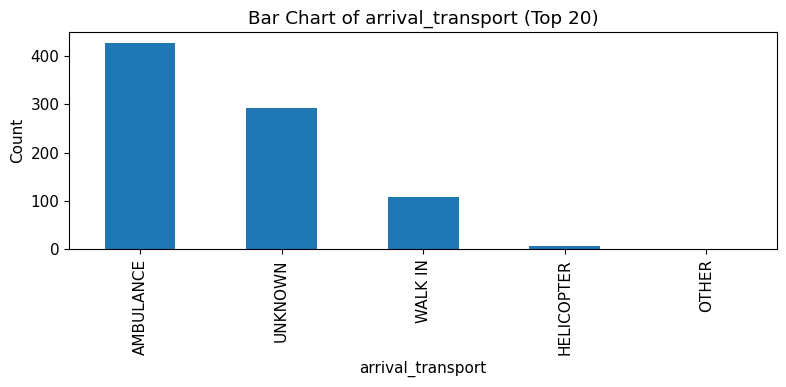


=== Column: disposition ===


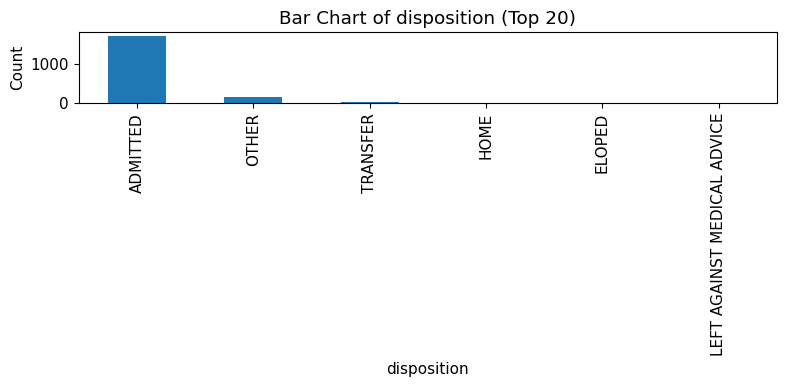


=== Column: dod ===


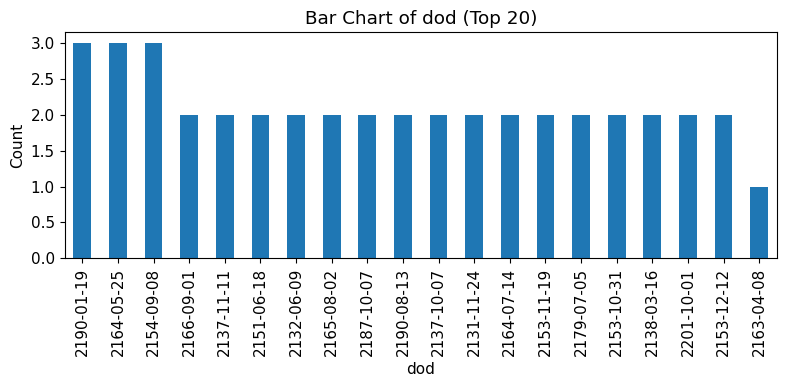


=== Column: first_troponin_charttime ===


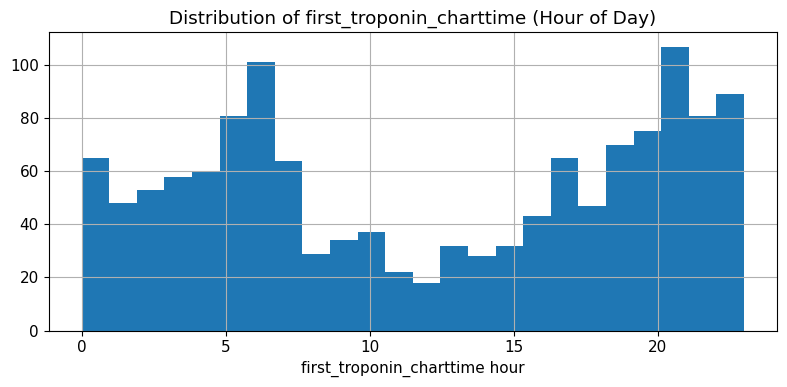


=== Column: troponin_end_charttime ===


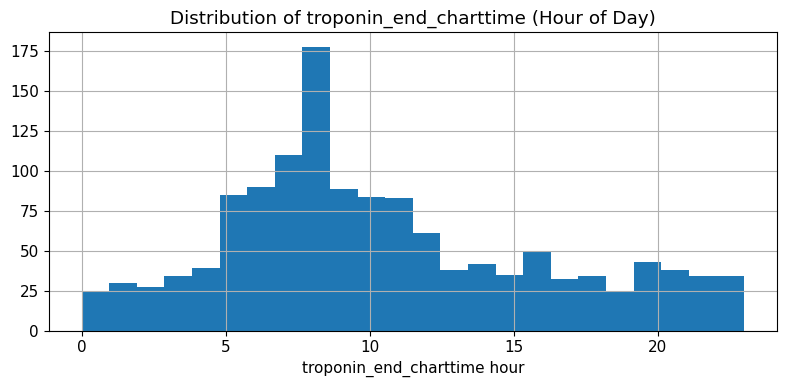


=== Column: first_troponin_positive_charttime ===


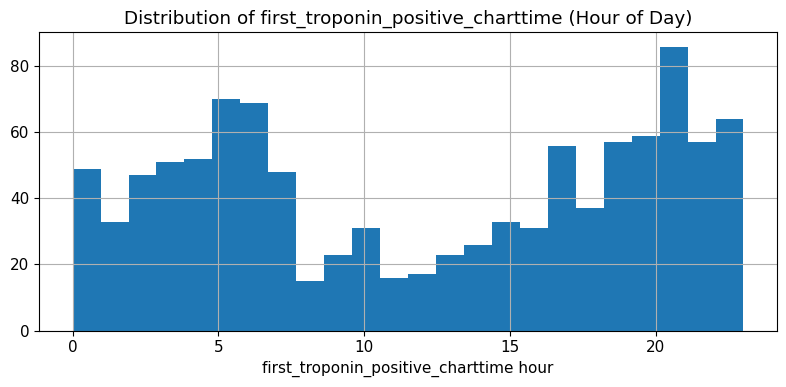


=== Column: troponin_count ===


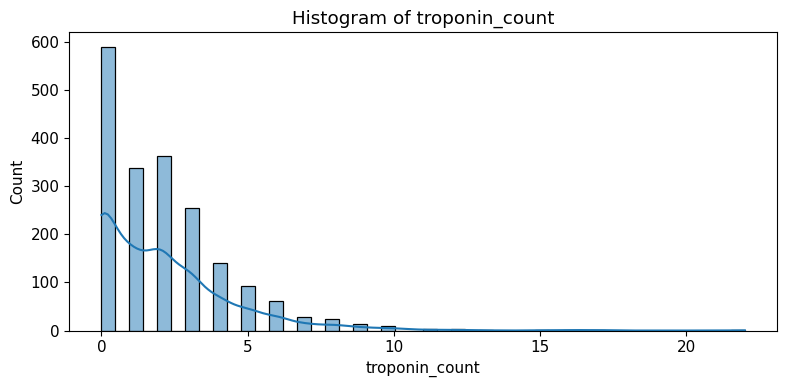


=== Column: ed_intime ===


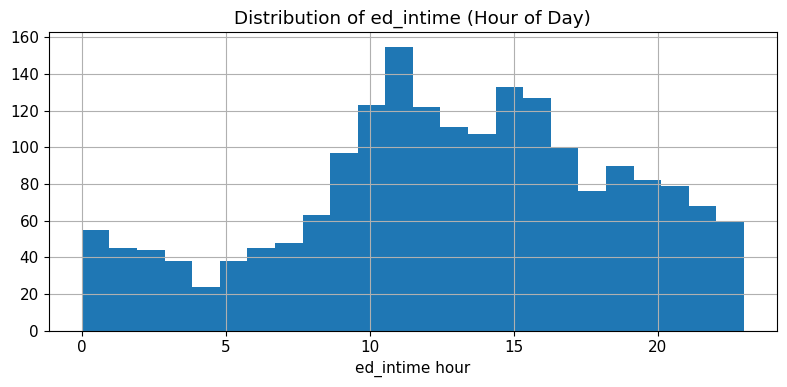


=== Column: ed_outtime ===


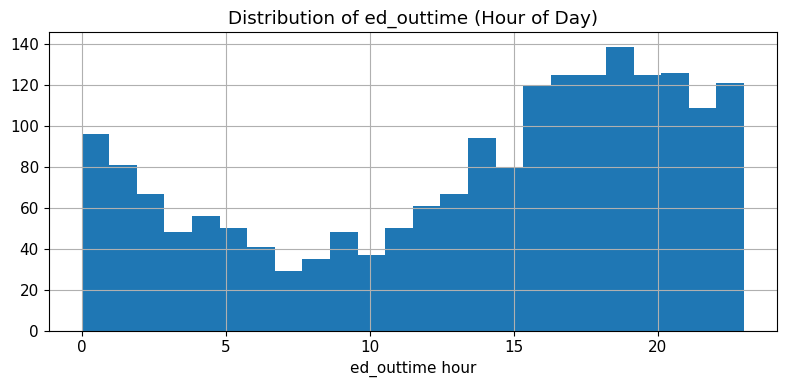


=== Column: ed_los ===


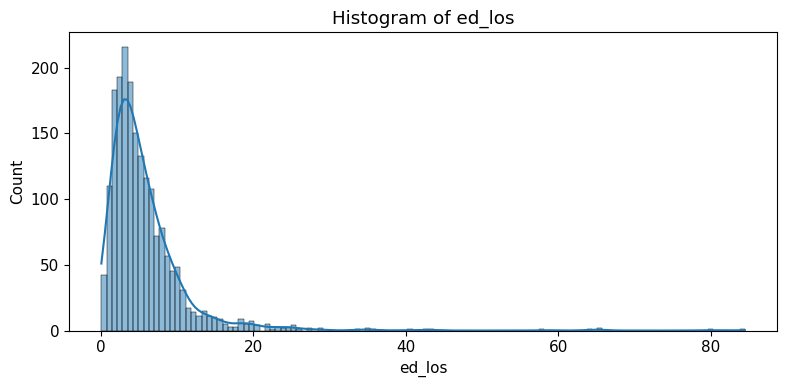


=== Column: ed_stay_id ===


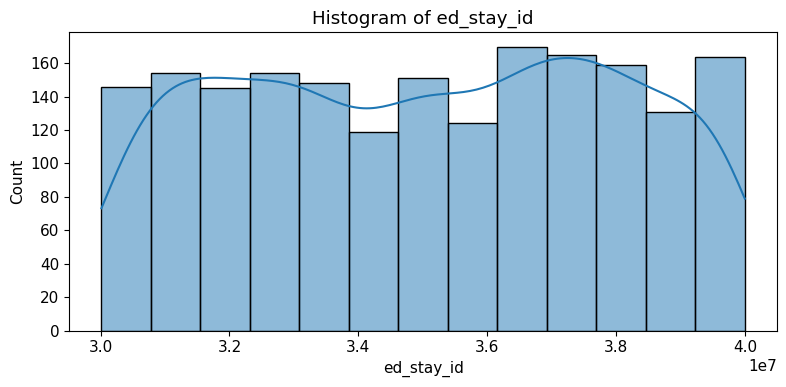

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["font.size"] = 11


# =========================================================
# 1. Load
# =========================================================
df = pd.read_csv("./cohort/cohort_ver47_with_cci_hfrs.csv")

# datetime 변환
date_cols = [
    "ed_intime","ed_outtime",
    "first_troponin_charttime","troponin_end_charttime",
    "first_troponin_positive_charttime"
]
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")


# =========================================================
# 2. ED + Troponin 컬럼 목록
# =========================================================
eda_cols = [
    "arrival_transport","disposition","los_days","dod",
    "first_troponin_charttime","troponin_end_charttime",
    "first_troponin_positive_charttime","troponin_count",
    "ed_intime","ed_outtime","ed_los","ed_stay_id"
]

eda_cols = [c for c in eda_cols if c in df.columns]


# =========================================================
# 3. 컬럼별 분포 시각화
# =========================================================
for col in eda_cols:
    print(f"\n=== Column: {col} ===")

    # ---- case 1: numeric ----
    if pd.api.types.is_numeric_dtype(df[col]):
        plt.figure(figsize=(8,4))
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()

    # ---- case 2: datetime → hour difference로 변환하여 그릴 수도 있음 ----
    elif pd.api.types.is_datetime64_any_dtype(df[col]):
        # datetime은 raw histogram 의미가 없으므로 countplot 형태로 대체
        plt.figure(figsize=(8,4))
        df[col].dt.hour.dropna().hist(bins=24)
        plt.title(f"Distribution of {col} (Hour of Day)")
        plt.xlabel(f"{col} hour")
        plt.tight_layout()
        plt.show()

    # ---- case 3: categorical / object ----
    else:
        plt.figure(figsize=(8,4))
        df[col].value_counts().head(20).plot(kind="bar")
        plt.title(f"Bar Chart of {col} (Top 20)")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


[INFO] 사용 LOS 컬럼: icu_los
[INFO] 사망 flag 컬럼: death_flag (1=사망, 0=생존)
[INFO] 분석 샘플 수: 708


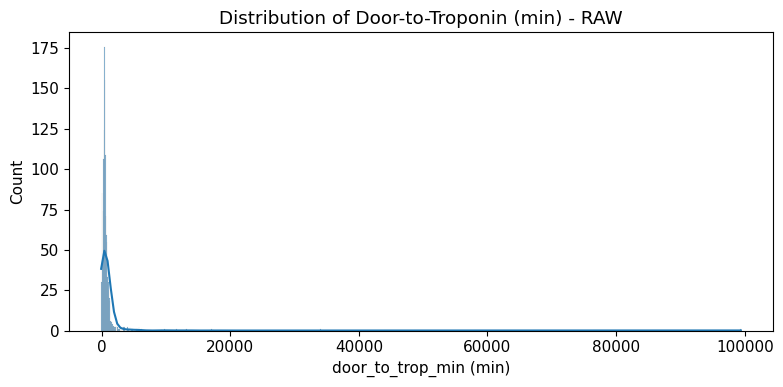

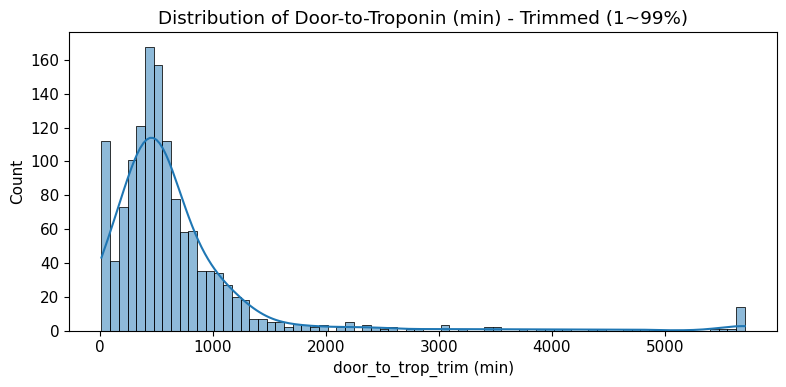

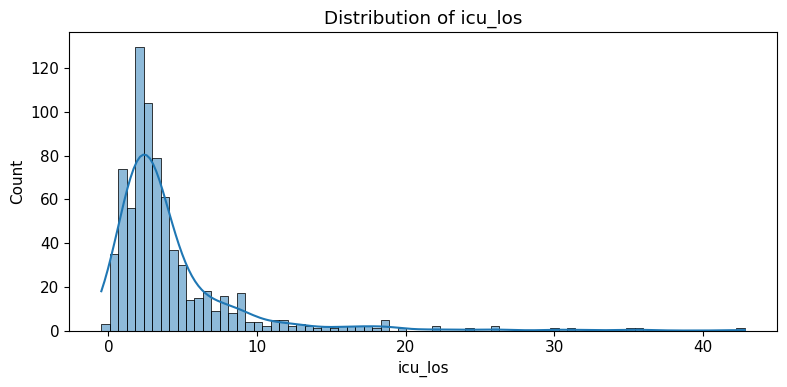


[기본 비율]
사망 비율:
death_flag
0    0.846114
1    0.153886
Name: ratio, dtype: float64

Troponin 검사 유무 비율:
has_troponin
1    0.693782
0    0.306218
Name: ratio, dtype: float64


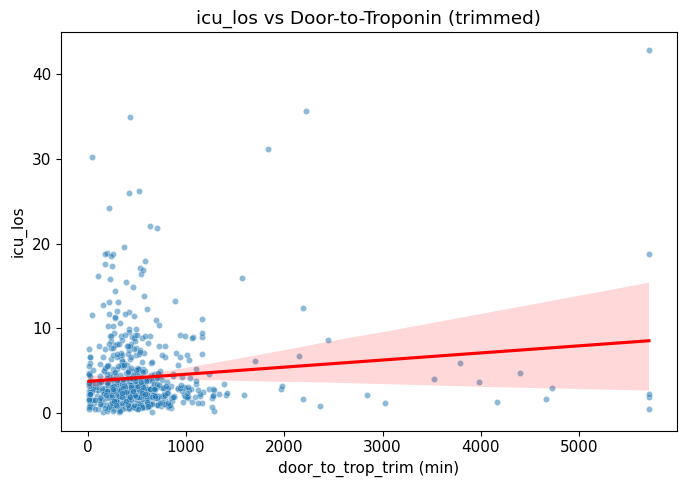


[상관계수: LOS vs delay]
Pearson corr  : 0.1246
Spearman corr : -0.0416

[delay 4분위별 icu_los 요약]
           count      mean       std       min       25%       50%       75%  \
delay_q                                                                        
Q1(가장 빠름)  177.0  4.531668  4.710267  0.055093  1.767095  3.040000  5.070000   
Q2         177.0  4.093903  4.071440  0.148356  2.020000  3.025671  4.724803   
Q3         177.0  3.903482  3.624510  0.404595  1.945347  2.830000  4.270000   
Q4(가장 늦음)  177.0  4.297042  5.522713  0.126632  1.890000  2.810000  4.370000   

             max  
delay_q           
Q1(가장 빠름)  30.22  
Q2         34.91  
Q3         26.16  
Q4(가장 늦음)  42.80  


C:\Users\User\AppData\Local\Temp\ipykernel_17940\1089709340.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  los_by_q = df_anal.groupby("delay_q")[los_col].describe()
C:\Users\User\AppData\Local\Temp\ipykernel_17940\1089709340.py:185: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_17940\1089709340.py:185: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_17940\1089709340.py:185: UserWarning: Glyph 48736 (\N{HANGUL SYLLABLE BBA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_17940\1089709340.py:185: UserWarning: Glyph 47492 (\N{HANGUL SYLLABLE R

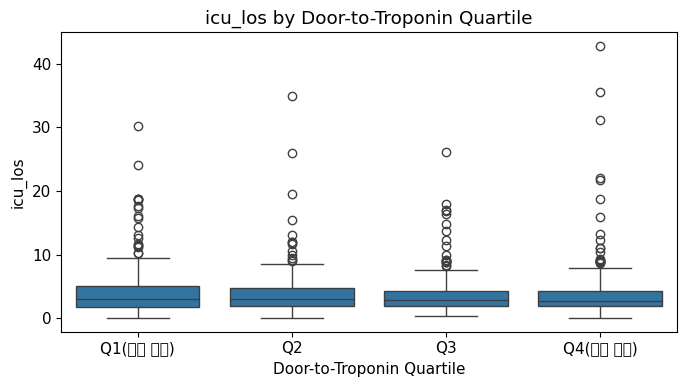

C:\Users\User\AppData\Local\Temp\ipykernel_17940\1089709340.py:205: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_17940\1089709340.py:205: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_17940\1089709340.py:205: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_17940\1089709340.py:205: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtoo

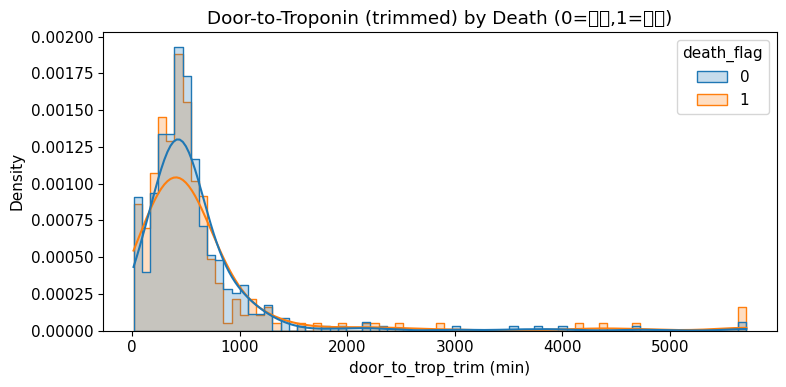

C:\Users\User\AppData\Local\Temp\ipykernel_17940\1089709340.py:214: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_17940\1089709340.py:214: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_17940\1089709340.py:214: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_17940\1089709340.py:214: UserWarning: Glyph 47581 (\N{HANGUL SYLLABLE MANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtoo

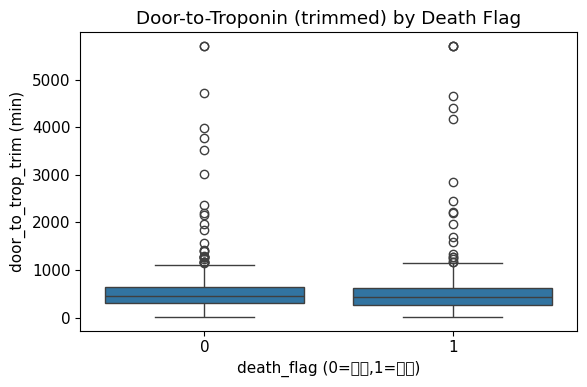


[death_flag별 Door-to-Troponin 통계]
            count        mean         std    min    25%    50%    75%      max
death_flag                                                                    
0           463.0  559.408121  585.062360  12.38  298.0  460.0  632.5  5709.34
1           245.0  610.409796  812.687032  12.38  274.0  441.0  626.0  5709.34

[delay vs 사망 상관계수] (point-biserial) : 0.0361


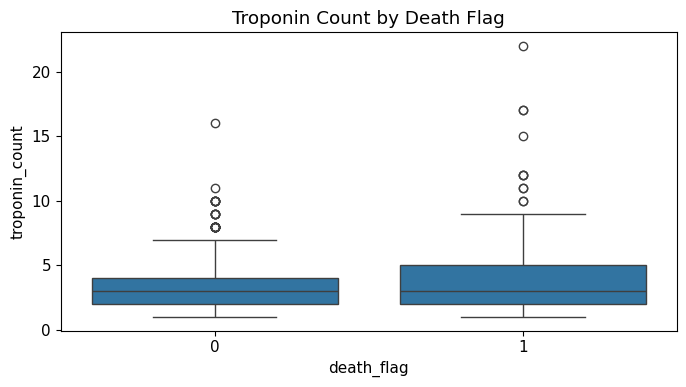


[death_flag별 Troponin count 통계]
            count      mean       std  min  25%  50%  75%   max
death_flag                                                     
0           463.0  3.393089  2.024984  1.0  2.0  3.0  4.0  16.0
1           245.0  4.036735  2.966113  1.0  2.0  3.0  5.0  22.0


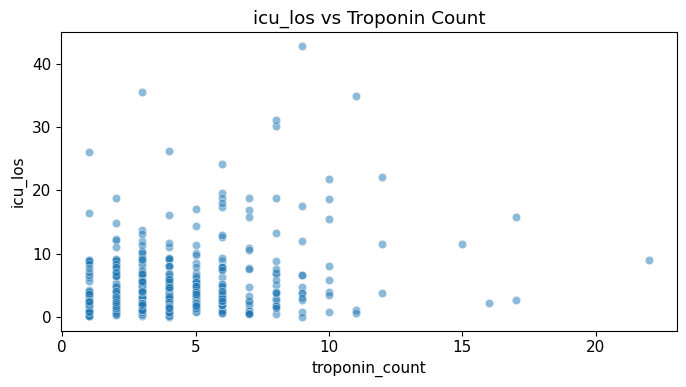


=== EDA 완료 ===


In [6]:
"""
Troponin delay vs 사망 / LOS 관계 분석을 위한 EDA 코드

- door_to_troponin_min 생성 (ED 기준)
- LOS / 사망 outcome 자동 선택
- 단변량 분포 확인
- delay vs LOS / death 관계 시각화 & 통계 요약
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 11

# ---------------------------------------------------
# 0. 데이터 로드 & 기본 전처리
# ---------------------------------------------------
DATA_PATH = "./cohort/cohort_ver47_with_cci_hfrs.csv"  # 경로만 수정해서 사용

df = pd.read_csv(DATA_PATH)

# 날짜형 변환
datetime_cols = [
    "ed_intime",
    "ed_outtime",
    "admittime",
    "dischtime",
    "first_troponin_charttime",
    "troponin_end_charttime",
    "first_troponin_positive_charttime",
    "dod",
]
for c in datetime_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# ---------------------------------------------------
# 1. Troponin 관련 파생 변수 생성
# ---------------------------------------------------
# 1) Troponin 검사 유무 flag
if "troponin_count" in df.columns:
    df["has_troponin"] = (df["troponin_count"] > 0).astype(int)
else:
    df["has_troponin"] = (~df["first_troponin_charttime"].isna()).astype(int)

# 2) ED 기준 door-to-troponin (분 단위)
if "ed_intime" not in df.columns or "first_troponin_charttime" not in df.columns:
    raise ValueError("ed_intime 또는 first_troponin_charttime 컬럼이 없습니다.")

df["door_to_trop_min"] = (
    (df["first_troponin_charttime"] - df["ed_intime"])
    .dt.total_seconds()
    / 60
)

# 음수/매우 큰 값이 많기 때문에, 분석용 trimmed 버전도 생성
delay = df["door_to_trop_min"]
q1, q99 = delay.quantile([0.01, 0.99])
df["door_to_trop_trim"] = delay.clip(lower=q1, upper=q99)


# ---------------------------------------------------
# 2. Outcome 정의: LOS & Death
# ---------------------------------------------------
from typing import Optional

def choose_los_column(df: pd.DataFrame) -> Optional[str]:
    candidates = ["los_days", "icu_los", "hosp_los", "los"]
    for c in candidates:
        if c in df.columns:
            return c
    return None


los_col = choose_los_column(df)

# 사망 flag: in_hosp_death 있으면 사용, 없으면 dod 기준으로 생성
if "in_hosp_death" in df.columns:
    df["death_flag"] = df["in_hosp_death"].astype(int)
else:
    df["death_flag"] = df["dod"].notna().astype(int)

print(f"[INFO] 사용 LOS 컬럼: {los_col}")
print(f"[INFO] 사망 flag 컬럼: death_flag (1=사망, 0=생존)")

# 분석에 사용할 서브셋 (LOS, delay 모두 존재)
analysis_cols = ["door_to_trop_min", "door_to_trop_trim", "death_flag"]
if los_col is not None:
    analysis_cols.append(los_col)

df_anal = df[analysis_cols].dropna()
print(f"[INFO] 분석 샘플 수: {len(df_anal)}")


# ---------------------------------------------------
# 3. 단변량 분포 EDA
# ---------------------------------------------------
# 3-1. door_to_troponin 분포 (raw)
plt.figure(figsize=(8, 4))
sns.histplot(df["door_to_trop_min"].dropna(), kde=True)
plt.title("Distribution of Door-to-Troponin (min) - RAW")
plt.xlabel("door_to_trop_min (min)")
plt.tight_layout()
plt.show()

# 3-2. door_to_troponin 분포 (trimmed 1~99%)
plt.figure(figsize=(8, 4))
sns.histplot(df["door_to_trop_trim"].dropna(), kde=True)
plt.title("Distribution of Door-to-Troponin (min) - Trimmed (1~99%)")
plt.xlabel("door_to_trop_trim (min)")
plt.tight_layout()
plt.show()

# 3-3. LOS 분포
if los_col is not None:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[los_col].dropna(), kde=True)
    plt.title(f"Distribution of {los_col}")
    plt.xlabel(los_col)
    plt.tight_layout()
    plt.show()

# 3-4. 사망률 & troponin 검사 비율
print("\n[기본 비율]")
print("사망 비율:")
print(df["death_flag"].value_counts(normalize=True).rename("ratio"))

print("\nTroponin 검사 유무 비율:")
print(df["has_troponin"].value_counts(normalize=True).rename("ratio"))


# ---------------------------------------------------
# 4. delay vs LOS 관계 EDA
# ---------------------------------------------------
if los_col is not None:
    # 4-1. scatter + 회귀선
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        data=df_anal,
        x="door_to_trop_trim",
        y=los_col,
        alpha=0.5,
        s=20,
    )
    sns.regplot(
        data=df_anal,
        x="door_to_trop_trim",
        y=los_col,
        scatter=False,
        color="red",
    )
    plt.title(f"{los_col} vs Door-to-Troponin (trimmed)")
    plt.xlabel("door_to_trop_trim (min)")
    plt.ylabel(los_col)
    plt.tight_layout()
    plt.show()

    # 4-2. 상관계수 (Pearson / Spearman)
    valid = df_anal[["door_to_trop_trim", los_col]].dropna()
    pearson_corr = valid["door_to_trop_trim"].corr(valid[los_col], method="pearson")
    spearman_corr = valid["door_to_trop_trim"].corr(valid[los_col], method="spearman")

    print(f"\n[상관계수: LOS vs delay]")
    print(f"Pearson corr  : {pearson_corr:.4f}")
    print(f"Spearman corr : {spearman_corr:.4f}")

    # 4-3. delay quartile별 LOS 요약
    df_anal["delay_q"] = pd.qcut(
        df_anal["door_to_trop_trim"],
        q=4,
        labels=["Q1(가장 빠름)", "Q2", "Q3", "Q4(가장 늦음)"],
    )
    los_by_q = df_anal.groupby("delay_q")[los_col].describe()
    print(f"\n[delay 4분위별 {los_col} 요약]")
    print(los_by_q)

    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df_anal, x="delay_q", y=los_col)
    plt.title(f"{los_col} by Door-to-Troponin Quartile")
    plt.xlabel("Door-to-Troponin Quartile")
    plt.ylabel(los_col)
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------
# 5. delay vs 사망 관계 EDA
# ---------------------------------------------------
# 5-1. 사망군 vs 생존군의 delay 분포 (KDE / hist)
plt.figure(figsize=(8, 4))
sns.histplot(
    data=df_anal,
    x="door_to_trop_trim",
    hue="death_flag",
    kde=True,
    stat="density",
    common_norm=False,
    element="step",
)
plt.title("Door-to-Troponin (trimmed) by Death (0=생존,1=사망)")
plt.xlabel("door_to_trop_trim (min)")
plt.tight_layout()
plt.show()

# 5-2. boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_anal, x="death_flag", y="door_to_trop_trim")
plt.title("Door-to-Troponin (trimmed) by Death Flag")
plt.xlabel("death_flag (0=생존,1=사망)")
plt.ylabel("door_to_trop_trim (min)")
plt.tight_layout()
plt.show()

# 5-3. 그룹별 평균 / 중앙값 비교
delay_stats_by_death = df_anal.groupby("death_flag")["door_to_trop_trim"].describe()
print("\n[death_flag별 Door-to-Troponin 통계]")
print(delay_stats_by_death)

# 5-4. point-biserial correlation (binary vs continuous → Pearson 동일)
valid2 = df_anal[["door_to_trop_trim", "death_flag"]].dropna()
death_corr = valid2["door_to_trop_trim"].corr(valid2["death_flag"])
print(f"\n[delay vs 사망 상관계수] (point-biserial) : {death_corr:.4f}")


# ---------------------------------------------------
# 6. Troponin 횟수 vs Outcome (보너스 EDA)
# ---------------------------------------------------
if "troponin_count" in df.columns and los_col is not None:
    tmp = df_anal.join(df["troponin_count"])

    plt.figure(figsize=(7, 4))
    sns.boxplot(data=tmp, x="death_flag", y="troponin_count")
    plt.title("Troponin Count by Death Flag")
    plt.xlabel("death_flag")
    plt.ylabel("troponin_count")
    plt.tight_layout()
    plt.show()

    print("\n[death_flag별 Troponin count 통계]")
    print(tmp.groupby("death_flag")["troponin_count"].describe())

    # LOS와의 관계
    plt.figure(figsize=(7, 4))
    sns.scatterplot(data=tmp, x="troponin_count", y=los_col, alpha=0.5)
    plt.title(f"{los_col} vs Troponin Count")
    plt.tight_layout()
    plt.show()

print("\n=== EDA 완료 ===")


Death ratio:
death_flag
0    0.846114
1    0.153886
Name: proportion, dtype: float64
Valid rows after trimming: 1339


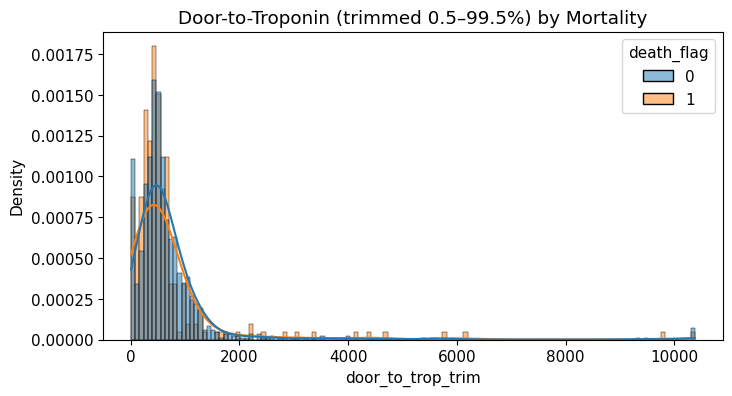

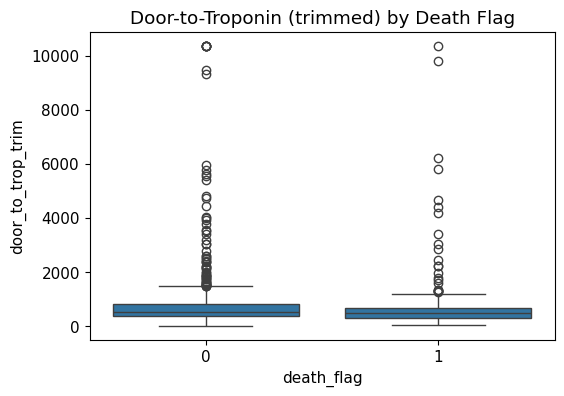


=== Delay Statistics by Death Flag (trimmed) ===
             count        mean          std   min     25%    50%     75%  \
death_flag                                                                 
0           1073.0  713.245191  1036.542329  6.69  341.00  510.0  788.00   
1            266.0  692.713195  1126.714724  9.00  281.25  458.0  649.25   

                 max  
death_flag            
0           10375.71  
1           10375.71  

=== Statistical Tests ===
Mann–Whitney U-test p-value : 0.00689
T-test p-value              : 0.78715

Point-biserial correlation(delay vs death) = -0.0078

=== Mortality Rate by Delay Quartile ===
delay_q
Q1(빠름)    0.238806
Q2        0.202985
Q3        0.214925
Q4(늦음)    0.137725
Name: death_flag, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_17940\2915860995.py:112: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mortality_by_q = df_anal.groupby("delay_q")["death_flag"].mean()
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48736 (\N{HANGUL SYLLABLE BBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47492 (\N{HANGUL SYLLABLE REUM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45734 (\N{HANGUL SYLLABLE NEUJ}) missing from font(s) DejaVu Sans.
  fig.canvas

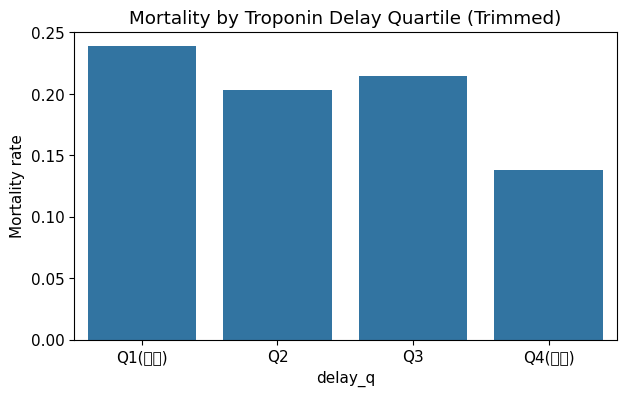


=== EDA Completed (Trimmed) ===


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["font.size"] = 11

# --------------------------------------
# 1. Load data (새 경로 적용)
# --------------------------------------
df = pd.read_csv("./cohort/cohort_ver47_with_cci_hfrs.csv")

datetime_cols = [
    "ed_intime","first_troponin_charttime","dod",
]
for c in datetime_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")


# --------------------------------------
# 2. Mortality flag
# --------------------------------------
if "in_hosp_death" in df.columns:
    df["death_flag"] = df["in_hosp_death"].astype(int)
else:
    df["death_flag"] = df["dod"].notna().astype(int)

print("Death ratio:")
print(df["death_flag"].value_counts(normalize=True))


# --------------------------------------
# 3. Door-to-troponin delay (min)
# --------------------------------------
df["door_to_trop_min"] = (
    (df["first_troponin_charttime"] - df["ed_intime"])
    .dt.total_seconds() / 60
)

# --------------------------------------
# 4. Outlier 제거: 0.5% ~ 99.5%
# --------------------------------------
delay = df["door_to_trop_min"].dropna()
low, high = delay.quantile([0.005, 0.995])

df["door_to_trop_trim"] = df["door_to_trop_min"].clip(low, high)

df_anal = df[["door_to_trop_trim","death_flag"]].dropna()
print(f"Valid rows after trimming: {len(df_anal)}")

# --------------------------------------
# 5. Distribution (Survive vs Death)
# --------------------------------------
plt.figure(figsize=(8,4))
sns.histplot(
    data=df_anal,
    x="door_to_trop_trim",
    hue="death_flag",
    kde=True,
    stat="density",
    common_norm=False
)
plt.title("Door-to-Troponin (trimmed 0.5–99.5%) by Mortality")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=df_anal, x="death_flag", y="door_to_trop_trim")
plt.title("Door-to-Troponin (trimmed) by Death Flag")
plt.show()


# --------------------------------------
# 6. Group Stats
# --------------------------------------
print("\n=== Delay Statistics by Death Flag (trimmed) ===")
print(df_anal.groupby("death_flag")["door_to_trop_trim"].describe())


# --------------------------------------
# 7. Mann–Whitney & T-test
# --------------------------------------
alive = df_anal[df_anal["death_flag"]==0]["door_to_trop_trim"]
dead = df_anal[df_anal["death_flag"]==1]["door_to_trop_trim"]

u_stat, p_u = mannwhitneyu(alive, dead, alternative="two-sided")
t_stat, p_t = ttest_ind(alive, dead, equal_var=False)

print("\n=== Statistical Tests ===")
print(f"Mann–Whitney U-test p-value : {p_u:.5f}")
print(f"T-test p-value              : {p_t:.5f}")


# --------------------------------------
# 8. Correlation (point-biserial)
# --------------------------------------
corr = df_anal["door_to_trop_trim"].corr(df_anal["death_flag"])
print(f"\nPoint-biserial correlation(delay vs death) = {corr:.4f}")


# --------------------------------------
# 9. Quartiles
# --------------------------------------
df_anal["delay_q"] = pd.qcut(
    df_anal["door_to_trop_trim"],
    4,
    labels=["Q1(빠름)","Q2","Q3","Q4(늦음)"]
)

mortality_by_q = df_anal.groupby("delay_q")["death_flag"].mean()
print("\n=== Mortality Rate by Delay Quartile ===")
print(mortality_by_q)

plt.figure(figsize=(7,4))
sns.barplot(x=mortality_by_q.index, y=mortality_by_q.values)
plt.title("Mortality by Troponin Delay Quartile (Trimmed)")
plt.ylabel("Mortality rate")
plt.show()

print("\n=== EDA Completed (Trimmed) ===")
